<a href="https://colab.research.google.com/github/housemLassoued/ML-deployment/blob/main/TP3ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
from builtins import range, input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]
#training config:
epochs = 400
batch_size = 32
#define paths
covid_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID'
noncovid_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal'
#Use glob to grab images from path.jpg or jpeg
covid_files = glob (covid_path + '/*')
noncovid_files = glob (noncovid_path + '/*')

In [ ]:
#Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ", len (covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ", len (noncovid_files))

First 5 Covid Files:  ['/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1011.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1008.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1010.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1009.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1003.png']
Total Count:  169
First 5 NonCovid Files:  ['/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-10067.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-10063.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-10062.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/No

In [ ]:

#Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []
covid_images=[]
noncovid_images=[]
for i in range (len (covid_files)):
  image = cv2.imread(covid_files[i]) # read file
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image, (224,224)) # resize as per model covid_images.append(image) # append image
  covid_images.append(image)
  covid_labels.append('CT_COVID') #append class label
for i in range (len (noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

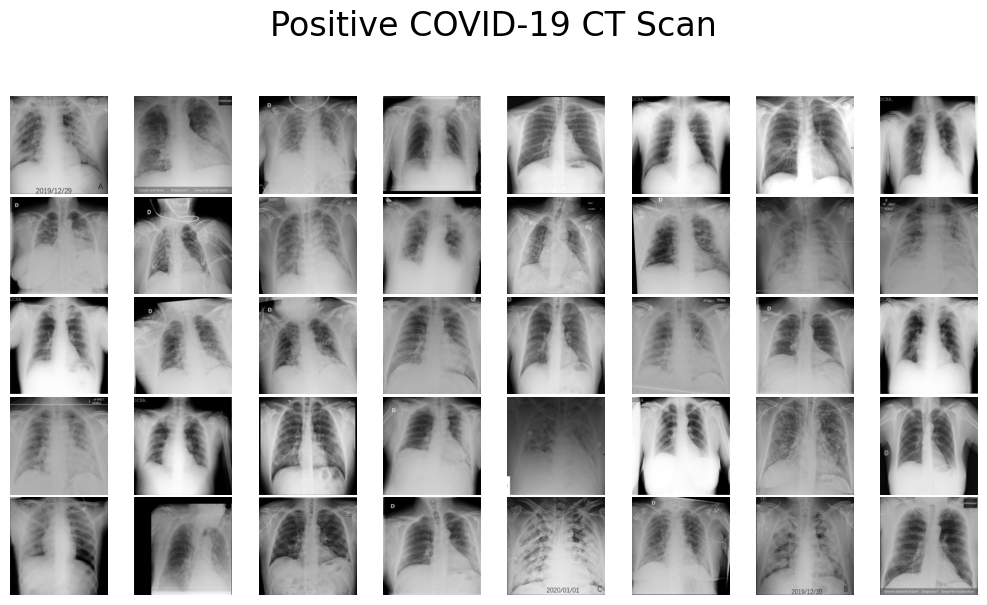

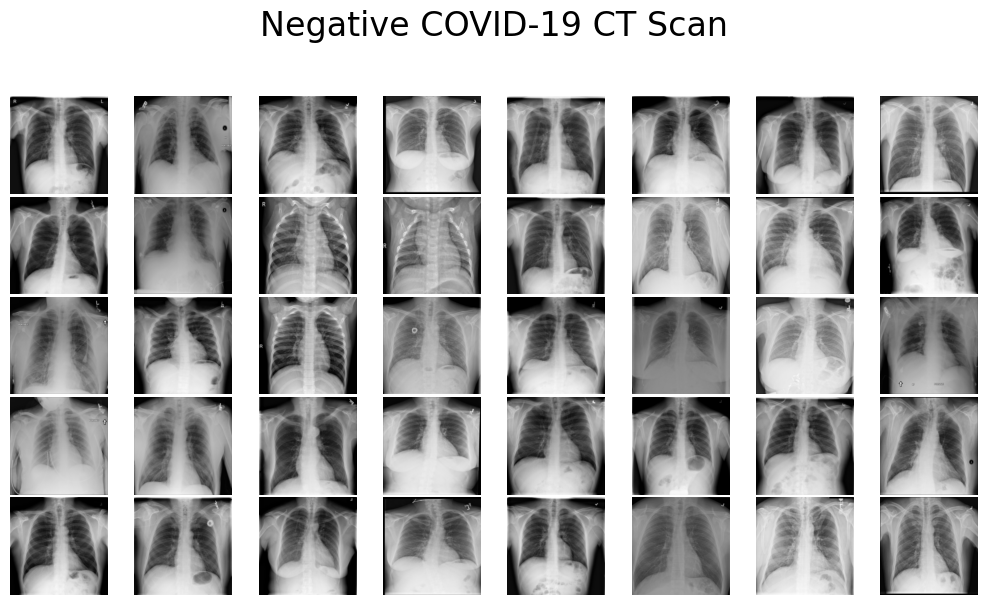

In [ ]:

# look at a random image for fun
def plot_images (images, title):
  nrows, ncols = 5, 8
  figsize = [10, 6]
  fig, ax = plt.subplots (nrows=nrows, ncols=ncols, figsize=figsize, facecolor= (1, 1, 1))
  for i, axi in enumerate (ax.flat):
    axi.imshow(images[i])
    axi.set_axis_off()
  plt.suptitle (title, fontsize=24)
  plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
  plt.show()
plot_images (covid_images, 'Positive COVID-19 CT Scan')
plot_images (noncovid_images, 'Negative COVID-19 CT Scan')

Le modéle prend des images sous la forme d'un tableau de pixels


In [ ]:
#Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

TRAIN and TEST split

In [ ]:

# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(covid_images, covid_labels, test_size=0.2)

noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(noncovid_images, noncovid_labels, test_size=0.2)


#Merge sets for both types of images.
X_train= np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories either 0 or 1, for our model
y_train =LabelBinarizer().fit_transform(y_train)
y_train =to_categorical (y_train)
y_test = LabelBinarizer().fit_transform(y_test)
y_test= to_categorical (y_test)

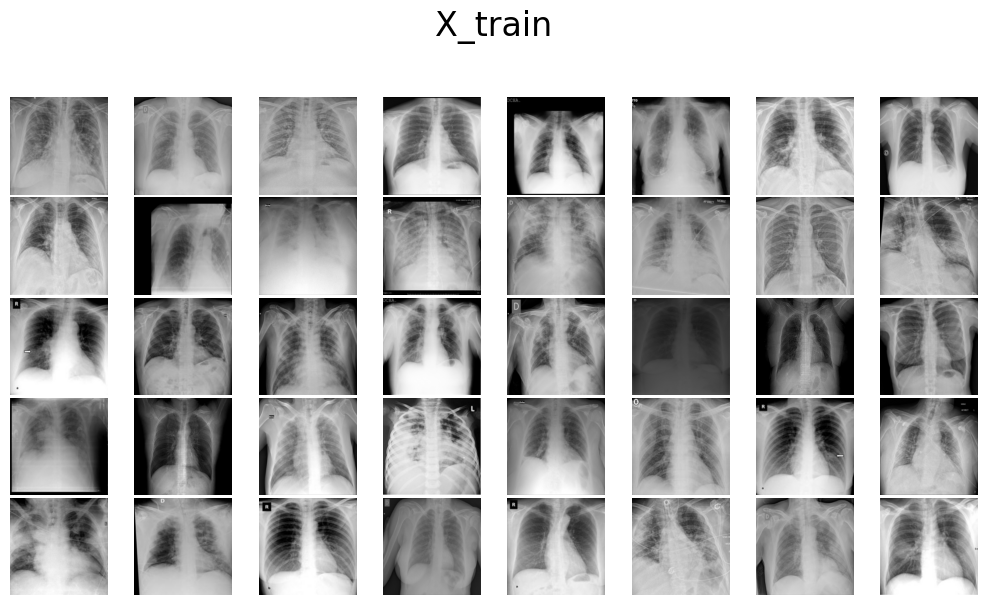

IndexError: index 34 is out of bounds for axis 0 with size 34

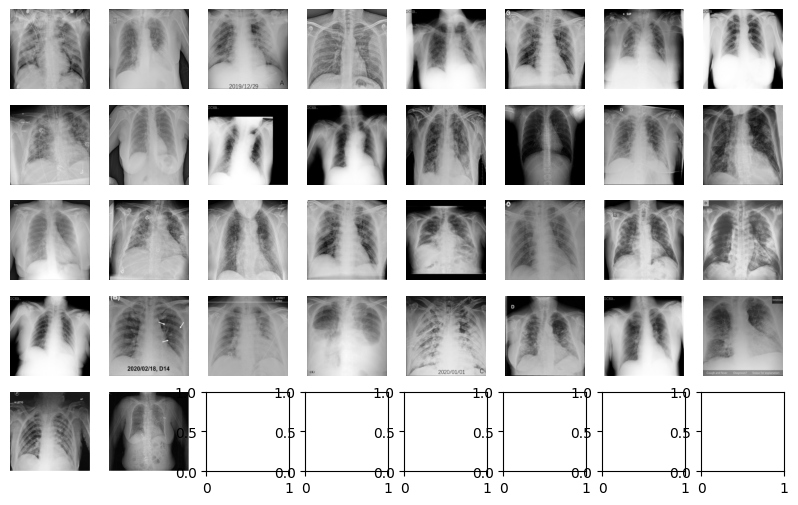

In [ ]:
plot_images (covid_x_train, 'X_train')
plot_images (covid_x_test, 'X_test')
#y_train and y test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

Construction et visualisation du modèle :

In [ ]:

#Building Model
vggModel= VGG16 (weights="imagenet", include_top=False, input_tensor=Input (shape=(224, 224, 3)))
outputs = vggModel.output
outputs = Flatten (name="flatten") (outputs)
outputs = Dropout (0.5) (outputs)
outputs = Dense (2, activation="sigmoid") (outputs)
model= Model (inputs=vggModel.input, outputs=outputs)
for layer in vggModel.layers:
  layer.trainable = False
model.compile(
loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy']
)

58889256/58889256 [==============================] - 1s 0us/step


Augmentation d'image
Pour s'entraîner sur des images à différentes positions, angles, retournements, etc.

Nous avons défini un générateur de données d'image pour former les modèles à des versions modifiées des images, comme à différents angles, retournements, rotations ou décalages.

In [ ]:
train_aug = ImageDataGenerator (
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  horizontal_flip=True
)

Training the model:
Ensuite, la formation du modèle a été effectuée, avec tous les paramètres requis

spécifiés comme suit:

In [ ]:



history=  model.fit (train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len (X_test) / batch_size,
                    steps_per_epoch= len (X_train) / batch_size,
                     epochs= epochs)




Epoch 1/400
8/8 [==============================] - 262s 33s/step - loss: 1.2244 - accuracy: 0.5682 - val_loss: 1.6059 - val_accuracy: 0.4925
Epoch 2/400
8/8 [==============================] - 279s 35s/step - loss: 1.3608 - accuracy: 0.5303 - val_loss: 0.4866 - val_accuracy: 0.7761
Epoch 3/400


In [ ]:
#Save Model and Weights
model.save('vgg_ct.h5')
model.save_weights('vgg_weights_ct.hdf5')
#Load saved model
model = load_model('vgg_ct.h5')

Faire des predictions:

Les prédictions ont été générées en exécutant les modèles entraînés sur des images de l'ensemble de test.
Les prédictions pour les 10 premières images de l'ensemble de données ont été tracées comme indiqué ci-dessous:

In [ ]:
y_pred = model.predict (X_test, batch_size=batch_size)
prediction-y_pred[0:10]
for index, probability in enumerate (prediction):
  if probability [1] > 0.5:
    plt.title('%.2f' (probability [1]*100) + '%COVID')
else:
    plt.title('%.2f'  ((1-probability[1])*100) + '%NonCOVID')
plt.imshow(X_test[index])

plt.show()
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

Plot de la matrice de confusion

In [ ]:

def plot_confusion_matrix (normalize):
  classes = ['COVID', 'NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin, normalize=normalize)
  sns.heatmap (cn, cmap='Reds', annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

Confusion Matrix without Normalization


NameError: name 'confusion_matrix' is not defined

Rapport de la classification

In [ ]:
from sklearn.metrics import classification_report
print(classification_report (y_test_bin, y_pred_bin))


NameError: name 'y_test_bin' is not defined


Plot de la précision << Accuracy >>>

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot (history.history['val accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'])
plt.savefig('vgg_ct_accuracy.png')
plt.show()

NameError: name 'plt' is not defined